In [1]:
from sklearn.metrics import accuracy_score

import torch, os, glob
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

from PIL import Image

In [ ]:
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
import torch

train_dir = "export/train"
test_dir  = "export/test"   


train_tf = T.Compose([
    T.Resize((64, 64)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

test_tf = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(train_dir, transform=train_tf)
test_ds  = datasets.ImageFolder(test_dir,  transform=test_tf)

print("Train classes     :", train_ds.classes)
print("Test  classes     :", test_ds.classes)
print("Train class_to_idx:", train_ds.class_to_idx)
print("Test  class_to_idx:", test_ds.class_to_idx)

BATCH_SIZE = 64
pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=pin)


Train classes     : ['0', '4']
Test  classes     : ['0', '4']
Train class_to_idx: {'0': 0, '4': 1}
Test  class_to_idx: {'0': 0, '4': 1}


In [ ]:
def make_mlp(in_shape=(3,64,64), num_classes=len(train_ds.classes), width=512, p=0.30):
    in_dim = in_shape[0]*in_shape[1]*in_shape[2]
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_dim, width), nn.GELU(), nn.Dropout(p),
        nn.Linear(width, width), nn.LayerNorm(width), nn.GELU(), nn.Dropout(p),
        nn.Linear(width, width//2), nn.GELU(), nn.Dropout(p),
        nn.Linear(width//2, num_classes) 
    )

model = make_mlp()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',       
    factor=0.5,       
    patience=2,       
)



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss = 0.0
    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device)
        y = y.to(device, dtype=torch.long)
        if train:
            optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total


best_acc = 0.0
for epoch in range(20):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)

    
    scheduler.step(te_acc)

    
    if te_acc > best_acc:
        best_acc = te_acc
        torch.save(model.state_dict(), "best_model.pt")

    
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch:02d} | LR:{current_lr:.6f} | "
          f"Train Loss:{tr_loss:.4f}/ Acc:{tr_acc:.3f} | "
          f"Val Loss:{te_loss:.4f}/ Acc:{te_acc:.3f}")


Epoch 00 | LR:0.000100 | Train Loss:0.7012/ Acc:0.490 | Val Loss:0.6916/ Acc:0.500
Epoch 01 | LR:0.000100 | Train Loss:0.6943/ Acc:0.514 | Val Loss:0.6913/ Acc:0.500
Epoch 02 | LR:0.000100 | Train Loss:0.6919/ Acc:0.526 | Val Loss:0.6923/ Acc:0.500
Epoch 03 | LR:0.000050 | Train Loss:0.6906/ Acc:0.531 | Val Loss:0.7058/ Acc:0.500
Epoch 04 | LR:0.000050 | Train Loss:0.6903/ Acc:0.526 | Val Loss:0.6854/ Acc:0.550
Epoch 05 | LR:0.000050 | Train Loss:0.6903/ Acc:0.538 | Val Loss:0.6840/ Acc:0.500
Epoch 06 | LR:0.000050 | Train Loss:0.6837/ Acc:0.547 | Val Loss:0.6754/ Acc:0.600
Epoch 07 | LR:0.000050 | Train Loss:0.6773/ Acc:0.567 | Val Loss:0.6611/ Acc:0.600
Epoch 08 | LR:0.000050 | Train Loss:0.6510/ Acc:0.619 | Val Loss:0.6012/ Acc:0.700
Epoch 09 | LR:0.000050 | Train Loss:0.5678/ Acc:0.725 | Val Loss:0.5064/ Acc:0.700
Epoch 10 | LR:0.000050 | Train Loss:0.5197/ Acc:0.741 | Val Loss:0.4301/ Acc:0.800
Epoch 11 | LR:0.000050 | Train Loss:0.4475/ Acc:0.788 | Val Loss:0.3015/ Acc:0.800
Epoc

Pred: 0 (idx=0) | 0: 0.887, 4: 0.113


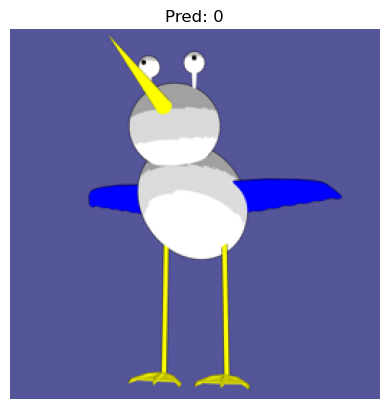

In [ ]:
img_path = "/Users/dylancanning/Desktop/UIB/AprenentatgeAutomatic/aa_2526/04_Imatges/export/test/0/000006.png"
model.eval()
img = Image.open(img_path).convert('RGB')
x = test_tf(img).unsqueeze(0).to(device)      

with torch.no_grad():
    logits = model(x)                           
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu()

pred_idx = int(torch.argmax(probs))
pred_name = train_ds.classes[pred_idx]
prob_str = ", ".join(f"{train_ds.classes[i]}: {probs[i]:.3f}" for i in range(len(train_ds.classes)))
print(f"Pred: {pred_name} (idx={pred_idx}) | {prob_str}")

if True:
    import matplotlib.pyplot as plt
    plt.imshow(Image.open(img_path).convert('RGB'))
    plt.title(f"Pred: {pred_name}")
    plt.axis('off'); plt.show()